In [1]:
from keras.utils import HDF5Matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.utils import to_categorical
from keras import backend as K
import keras.callbacks as cb
from keras.models import load_model
from keras.layers import Input, Dense, BatchNormalization, Dropout, Conv2D, MaxPool2D, Flatten, LeakyReLU, Concatenate, GlobalAveragePooling2D, UpSampling2D
from PIL import Image

import keras
import tensorflow
import tensorflow.compat.v1 as tf

import numpy as np
import pandas as pd
import imageio
import cv2
import pprint
import os
import re
import h5py
import PIL

import src.model as my_model
import src.pcam_loader as data
import src.adaptive_model as am

Using TensorFlow backend.


In [2]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    result = true_positives / (possible_positives + K.epsilon())
    return result


def my_own_preci(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    result = true_positives / (predicted_positives + K.epsilon())
    return result


def f1_score_metrics(y_true, y_pred):
    precision_result = precision(y_true, y_pred)
    recall_result = recall(y_true, y_pred)
    return 2*((precision_result*recall_result)/(precision_result+recall_result+K.epsilon()))


def f1_score_evaluate(precision, recall):
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# config = tf.ConfigProto(device_count={"CPU": 8})
# tensorflow.compat.v1.keras.backend.set_session(tf.Session(config=config))
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2517011343093747968
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4854028697
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17827457110077741275
physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:26:00.0, compute capability: 7.5"
]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:26:00.0, compute capability: 7.5



In [4]:
def load_dataset(dataset_type, path=None):
    if path:
        dataset_type = os.path.join(path, dataset_type)
    dataset = h5py.File(dataset_type + '_dataset.hdf5', 'r')
    dataset_name = list(dataset)

    y = []
    x = []
    for name in dataset_name:
        data = dataset[name]
        y.append(data.attrs['class_type'])
        x_item = data[:]
        x.append(x_item)

    y = np.array(y)
    y = y.reshape(len(y),1)
    x = np.array(x)
    dataset.close()
    return x, y

x_train, y_train = load_dataset('Train', 'data')
x_test, y_test = load_dataset('Test', 'data')

x_valid_length = round(len(x_test)/2)

x_valid = np.array(x_test[x_valid_length:])
x_test = np.array(x_test[:x_valid_length])

y_valid = y_test[x_valid_length:]
y_test = y_test[:x_valid_length]

In [5]:
# dataset = data.load_data()
# x_train, y_train, meta_train =  dataset[0]
# x_valid, y_valid, meta_valid =  dataset[1]
# x_test, y_test, meta_test =  dataset[2]

# y_train = np.array(y_train[:])
# y_train = y_train.reshape(-1, 1)
# y_valid = np.array(y_valid[:])
# y_valid = y_valid.reshape(-1, 1)
# y_test = np.array(y_test[:])
# y_test = y_test.reshape(-1, 1)

C:\Users\matho\anaconda3\lib\site-packages\keras\utils\io_utils.py:60: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(datapath)


In [6]:
batch_size = 10
epochs = 10
num_classes = 2
shape = x_train[0].shape
results = {}

In [7]:
def train(model, x_train, y_train, x_valid, y_valid, model_name):
    callbacks = [
        cb.callbacks.ModelCheckpoint(model_name, save_best_only=True)
    #     cb.callbacks.EarlyStopping(monitor = 'val_loss'),
    #     cb.callbacks.CSVLogger('model.csv', separator=',', append=False),
    #     cb.tensorboard_v1.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
    ]

    model.compile(loss=keras.losses.categorical_crossentropy, 
                  optimizer=keras.optimizers.Adam(), 
                  metrics=[
                      tensorflow.keras.metrics.Precision(),
                      'accuracy',
                      tensorflow.keras.metrics.Recall(),
                      tensorflow.keras.metrics.TruePositives(),
                      tensorflow.keras.metrics.FalsePositives(),
                      tensorflow.keras.metrics.FalseNegatives()
                          ])

    history = model.fit(
        x_train,
        to_categorical(y_train),
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(x_valid, to_categorical(y_valid)),
        shuffle='batch',
        callbacks=callbacks,
        use_multiprocessing=True, 
        workers=8
    )
    return history

In [8]:
counter = 0
def evaluate(model, x_test, y_test, history, model_name, results, counter):

    test_eval = model.evaluate(x_test, to_categorical(y_test), verbose=0)
    f1_score = f1_score_evaluate(test_eval[2], test_eval[3])
    results[model_name] = {'Test loss:': test_eval[0],
                            'Precision:': test_eval[1],
                            'Accuracy:': test_eval[2],
                            'Recall:': test_eval[3],
                            'TruePositives:': test_eval[4],
                            'FalsePositives:': test_eval[5],
                            'FalseNegatives:': test_eval[6],
                            'F1_score': f1_score}

    import matplotlib.pyplot as plt
    try:            
        graf_value= 'accuracy'
        plt.plot(history.history[graf_value])
        plt.plot(history.history['val_' + graf_value])
        plt.title('val_' + graf_value + ' ' + graf_value)
        plt.ylabel('val_' + graf_value + ', ' + graf_value )
        plt.xlabel('epochs')
        plt.legend(['val_' + graf_value, graf_value], loc='upper left')
        plt.savefig(os.path.join('data', 'giant_training', graf_value + '_' + re.sub('.h5', '.png', model_name)))
        plt.show()
    except:
        print("error")
    try: 
        graf_value= 'precision'
        if counter > 0:
            graf_value += '_' + str(counter)
        plt.plot(history.history[graf_value])
        plt.plot(history.history['val_' + graf_value])
        plt.title('val_' + graf_value + ' ' + graf_value)
        plt.ylabel('val_' + graf_value + ', ' + graf_value )
        plt.xlabel('epochs')
        plt.legend(['val_' + graf_value, graf_value], loc='upper left')
        plt.savefig(os.path.join('data', 'giant_training', graf_value + '_' + re.sub('.h5', '.png', model_name)))
        plt.show()
    except:
        print("error")
    try:
        graf_value= 'recall'
        if counter > 0:
            graf_value += '_' + str(counter)
        plt.plot(history.history[graf_value])
        plt.plot(history.history['val_' + graf_value])
        plt.title('val_' + graf_value + ' ' + graf_value)
        plt.ylabel('val_' + graf_value + ', ' + graf_value )
        plt.xlabel('epochs')
        plt.legend(['val_' + graf_value, graf_value], loc='upper left')
        plt.savefig(os.path.join('data', 'giant_training', graf_value + '_' + re.sub('.h5', '.png', model_name)))
        plt.show()
    except:
        print("error")
    try:
        graf_value= 'true_positives'
        if counter > 0:
            graf_value += '_' + str(counter)
        plt.plot(history.history[graf_value])
        plt.plot(history.history['val_' + graf_value])
        plt.title('val_' + graf_value + ' ' + graf_value)
        plt.ylabel('val_' + graf_value + ', ' + graf_value )
        plt.xlabel('epochs')
        plt.legend(['val_' + graf_value, graf_value], loc='upper left')
        plt.savefig(os.path.join('data', 'giant_training', graf_value + '_' + re.sub('.h5', '.png', model_name)))
        plt.show()
    except:
        print("error")
    try:
        graf_value= 'false_positives'
        if counter > 0:
            graf_value += '_' + str(counter)
        plt.plot(history.history[graf_value])
        plt.plot(history.history['val_' + graf_value])
        plt.title('val_' + graf_value + ' ' + graf_value)
        plt.ylabel('val_' + graf_value + ', ' + graf_value )
        plt.xlabel('epochs')
        plt.legend(['val_' + graf_value, graf_value], loc='upper left')
        plt.savefig(os.path.join('data', 'giant_training', graf_value + '_' + re.sub('.h5', '.png', model_name)))
        plt.show()
    except:
        print("error")
    try:
        graf_value= 'false_negatives'
        if counter > 0:
            graf_value += '_' + str(counter)
        plt.plot(history.history[graf_value])
        plt.plot(history.history['val_' + graf_value])
        plt.title('val_' + graf_value + ' ' + graf_value)
        plt.ylabel('val_' + graf_value + ', ' + graf_value )
        plt.xlabel('epochs')
        plt.legend(['val_' + graf_value, graf_value], loc='upper left')
        plt.savefig(os.path.join('data', 'giant_training', graf_value + '_' + re.sub('.h5', '.png', model_name)))
        plt.show()
    except:
        print("error")
        
    counter += 1

## BackPropagation

Train on 262144 samples, validate on 32768 samples
Epoch 1/10
262144/262144 [==============================] - 730s 3ms/step - loss: 0.2610 - precision: 0.8586 - accuracy: 0.8937 - recall: 0.8586 - true_positives: 115416.1250 - false_positives: 15663.7734 - false_negatives: 15663.7734 - val_loss: 0.6173 - val_precision: 0.8844 - val_accuracy: 0.7332 - val_recall: 0.8844 - val_true_positives: 246287.4844 - val_false_positives: 32246.3613 - val_false_negatives: 32246.3613
Epoch 2/10
262144/262144 [==============================] - 3614s 14ms/step - loss: 0.1980 - precision: 0.8884 - accuracy: 0.9222 - recall: 0.8884 - true_positives: 378925.2812 - false_positives: 47066.8242 - false_negatives: 47066.8242 - val_loss: 0.4502 - val_precision: 0.8945 - val_accuracy: 0.7856 - val_recall: 0.8945 - val_true_positives: 512918.7812 - val_false_positives: 60527.1016 - val_false_negatives: 60527.1016
Epoch 3/10
262144/262144 [==============================] - 693s 3ms/step - loss: 0.1745 - precisio

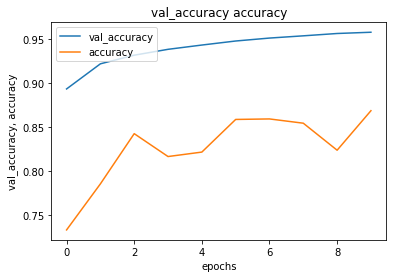

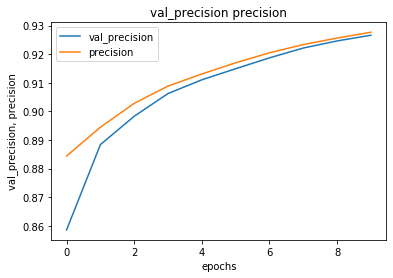

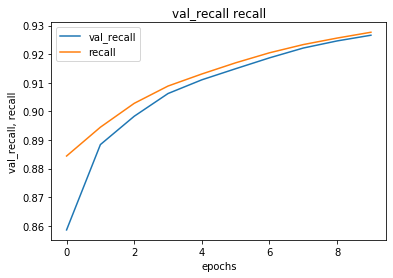

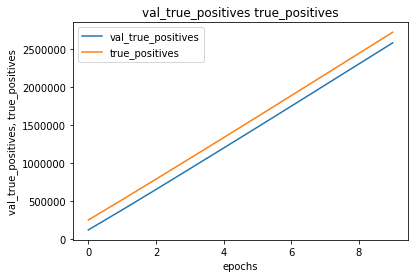

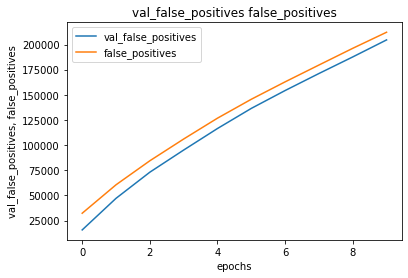

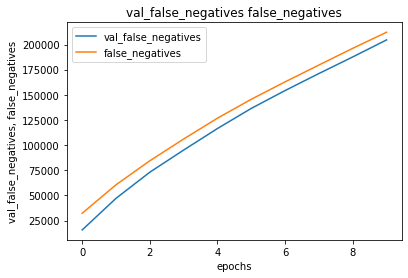

{'adaptive_backpropagation332.h5': {'Accuracy:': 0.813873291015625,
                                    'F1_score': 0.8666303907236992,
                                    'FalseNegatives:': 217372.46875,
                                    'FalsePositives:': 217372.46875,
                                    'Precision:': 0.9267013669013977,
                                    'Recall:': 0.9267013669013977,
                                    'Test loss:': 0.413744586177927,
                                    'TruePositives:': 2748147.75}}


In [9]:
# # Input layer with shape of data
# input_layer = am.input_layer(shape)
# model_name = 'adaptive_backpropagation332.h5'
#
# layers = am.unet_layer(input_layer, 3, 32)
#
# # Use Unet architecture as main model
# outputs_layer = am.unet_model(layers)
#
# # Output layer
# outputs_layer = am.flatten_layer(outputs_layer)
# outputs_layer = am.output_layer(outputs_layer)
#
# # Define model
# model = am.define_model(input_layer, outputs_layer)
#
# history = train(model, x_train, y_train, x_valid, y_valid, model_name)
# evaluate(model, x_test, y_test, history, model_name, results, counter)
# pprint.pprint(results)
#

Train on 262144 samples, validate on 32768 samples
Epoch 1/10
262144/262144 [==============================] - 647s 2ms/step - loss: 0.2717 - precision_1: 0.8477 - accuracy: 0.8863 - recall_1: 0.8477 - true_positives_1: 114257.8828 - false_positives_1: 16822.0508 - false_negatives_1: 16822.0508 - val_loss: 0.4350 - val_precision_1: 0.8813 - val_accuracy: 0.7970 - val_recall_1: 0.8813 - val_true_positives_1: 245431.8594 - val_false_positives_1: 33101.9219 - val_false_negatives_1: 33101.9219
Epoch 2/10
262144/262144 [==============================] - 645s 2ms/step - loss: 0.2052 - precision_1: 0.8877 - accuracy: 0.9182 - recall_1: 0.8877 - true_positives_1: 378565.0000 - false_positives_1: 47426.4141 - false_negatives_1: 47426.4141 - val_loss: 0.3765 - val_precision_1: 0.8940 - val_accuracy: 0.8202 - val_recall_1: 0.8940 - val_true_positives_1: 512621.1250 - val_false_positives_1: 60824.6406 - val_false_negatives_1: 60824.6406
Epoch 3/10
262144/262144 [==============================] - 6

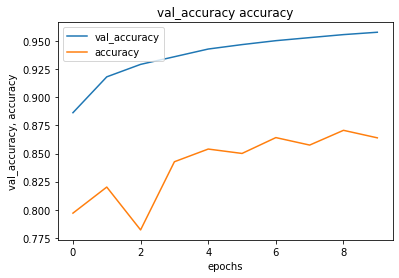

error
error
error
error
error
{'adaptive_backpropagation332.h5': {'Accuracy:': 0.813873291015625,
                                    'F1_score': 0.8666303907236992,
                                    'FalseNegatives:': 217372.46875,
                                    'FalsePositives:': 217372.46875,
                                    'Precision:': 0.9267013669013977,
                                    'Recall:': 0.9267013669013977,
                                    'Test loss:': 0.413744586177927,
                                    'TruePositives:': 2748147.75},
 'adaptive_backpropagation532.h5': {'Accuracy:': 0.832794189453125,
                                    'F1_score': 0.87708130893027,
                                    'FalseNegatives:': 218434.515625,
                                    'FalsePositives:': 218434.515625,
                                    'Precision:': 0.9263433814048767,
                                    'Recall:': 0.9263433814048767,
            

In [10]:
# # Input layer with shape of data
# input_layer = am.input_layer(shape)
# model_name = 'adaptive_backpropagation532.h5'
#
# layers = am.unet_layer(input_layer, 5, 32)
#
# # Use Unet architecture as main model
# outputs_layer = am.unet_model(layers)
#
# # Output layer
# outputs_layer = am.flatten_layer(outputs_layer)
# outputs_layer = am.output_layer(outputs_layer)
#
# # Define model
# model = am.define_model(input_layer, outputs_layer)
#
# history = train(model, x_train, y_train, x_valid, y_valid, model_name)
# evaluate(model, x_test, y_test, history, model_name, results, counter)
# pprint.pprint(results)
#

Train on 262144 samples, validate on 32768 samples
Epoch 1/10
262144/262144 [==============================] - 661s 3ms/step - loss: 0.2741 - precision_2: 0.8525 - accuracy: 0.8876 - recall_2: 0.8525 - true_positives_2: 114590.5938 - false_positives_2: 16489.4160 - false_negatives_2: 16489.4160 - val_loss: 0.4315 - val_precision_2: 0.8827 - val_accuracy: 0.8034 - val_recall_2: 0.8827 - val_true_positives_2: 245842.9688 - val_false_positives_2: 32691.0762 - val_false_negatives_2: 32691.0762
Epoch 2/10
262144/262144 [==============================] - 659s 3ms/step - loss: 0.2049 - precision_2: 0.8892 - accuracy: 0.9190 - recall_2: 0.8892 - true_positives_2: 379195.2188 - false_positives_2: 46796.5273 - false_negatives_2: 46796.5273 - val_loss: 0.4161 - val_precision_2: 0.8947 - val_accuracy: 0.8052 - val_recall_2: 0.8947 - val_true_positives_2: 513068.1250 - val_false_positives_2: 60377.6133 - val_false_negatives_2: 60377.6133
Epoch 3/10
262144/262144 [==============================] - 6

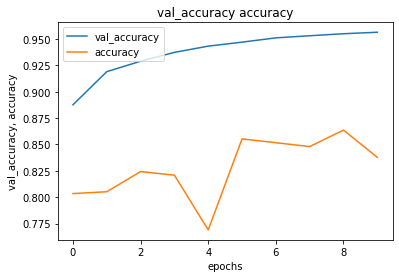

error
error
error
error
error
{'adaptive_backpropagation332.h5': {'Accuracy:': 0.813873291015625,
                                    'F1_score': 0.8666303907236992,
                                    'FalseNegatives:': 217372.46875,
                                    'FalsePositives:': 217372.46875,
                                    'Precision:': 0.9267013669013977,
                                    'Recall:': 0.9267013669013977,
                                    'Test loss:': 0.413744586177927,
                                    'TruePositives:': 2748147.75},
 'adaptive_backpropagation532.h5': {'Accuracy:': 0.832794189453125,
                                    'F1_score': 0.87708130893027,
                                    'FalseNegatives:': 218434.515625,
                                    'FalsePositives:': 218434.515625,
                                    'Precision:': 0.9263433814048767,
                                    'Recall:': 0.9263433814048767,
            

In [11]:
# # Input layer with shape of data
# input_layer = am.input_layer(shape)
# model_name = 'adaptive_backpropagation732.h5'
#
# layers = am.unet_layer(input_layer, 7, 32)
#
# # Use Unet architecture as main model
# outputs_layer = am.unet_model(layers)
#
# # Output layer
# outputs_layer = am.flatten_layer(outputs_layer)
# outputs_layer = am.output_layer(outputs_layer)
#
# # Define model
# model = am.define_model(input_layer, outputs_layer)
#
# history = train(model, x_train, y_train, x_valid, y_valid, model_name)
# evaluate(model, x_test, y_test, history, model_name, results, counter)
# pprint.pprint(results)

## Gabor filters

In [ ]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_gabor532.h5'

layers = am.gabor_layer(input_layer, 5, 32)

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model 
model = am.define_model(input_layer, outputs_layer)

# Add filters from gabor function
weights, filters = am.gabor_filter(model)
model.layers[1].set_weights(weights)

history = train(model, x_train, y_train, x_valid, y_valid, model_name)
evaluate(model, x_test, y_test, history, model_name, results, counter)
pprint.pprint(results)

In [ ]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_gabor732.h5'

layers = am.gabor_layer(input_layer, 7, 32)

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model 
model = am.define_model(input_layer, outputs_layer)

# Add filters from gabor function
weights, filters = am.gabor_filter(model)
model.layers[1].set_weights(weights)

history = train(model, x_train, y_train, x_valid, y_valid, model_name)
evaluate(model, x_test, y_test, history, model_name, results, counter)
pprint.pprint(results)

In [ ]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_gabor932.h5'

layers = am.gabor_layer(input_layer, 9, 32) 

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model 
model = am.define_model(input_layer, outputs_layer)

# Add filters from gabor function
weights, filters = am.gabor_filter(model)
model.layers[1].set_weights(weights)

history = train(model, x_train, y_train, x_valid, y_valid, model_name)
evaluate(model, x_test, y_test, history, model_name, results, counter)
pprint.pprint(results)

Train on 262144 samples, validate on 32768 samples
Epoch 1/10
262144/262144 [==============================] - 6547s 25ms/step - loss: 0.3078 - precision: 0.8325 - accuracy: 0.8741 - recall: 0.8325 - true_positives: 112482.5156 - false_positives: 18597.3691 - false_negatives: 18597.3691 - val_loss: 0.4612 - val_precision: 0.8694 - val_accuracy: 0.7930 - val_recall: 0.8694 - val_true_positives: 242142.1562 - val_false_positives: 36391.5625 - val_false_negatives: 36391.5625
Epoch 2/10
262144/262144 [==============================] - 10298s 39ms/step - loss: 0.2354 - precision: 0.8760 - accuracy: 0.9057 - recall: 0.8760 - true_positives: 373579.0625 - false_positives: 52413.6836 - false_negatives: 52413.6836 - val_loss: 0.4360 - val_precision: 0.8819 - val_accuracy: 0.8044 - val_recall: 0.8819 - val_true_positives: 505710.4688 - val_false_positives: 67735.2969 - val_false_negatives: 67735.2969
Epoch 3/10
262144/262144 [==============================] - 9054s 35ms/step - loss: 0.2086 - pre

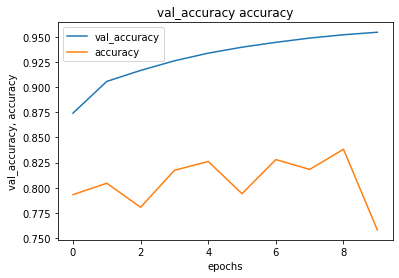

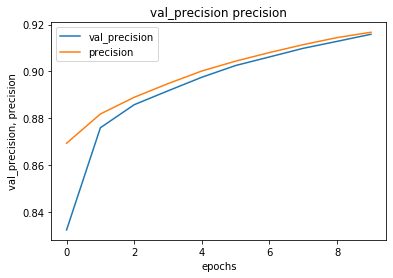

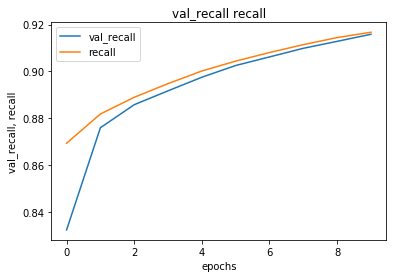

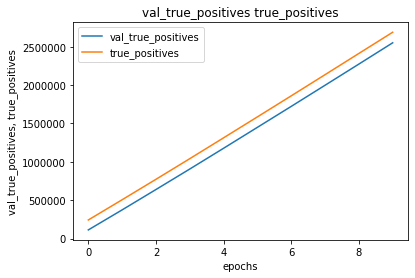

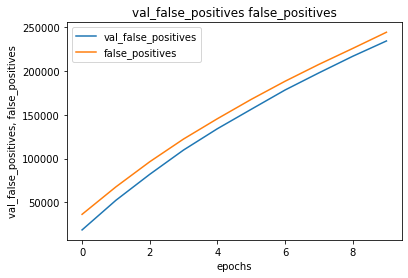

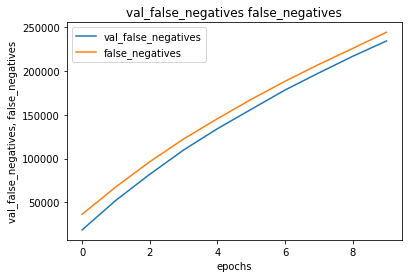

{'adaptive_gabor532.h5': {'Accuracy:': 0.770172119140625,
                          'F1_score': 0.8363735904313028,
                          'FalseNegatives:': 251995.5,
                          'FalsePositives:': 251995.5,
                          'Precision:': 0.9150263667106628,
                          'Recall:': 0.9150263667106628,
                          'Test loss:': 0.5123061910562683,
                          'TruePositives:': 2713524.75}}


In [9]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_gabor564.h5'

layers = am.gabor_layer(input_layer, 5, 64)

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model
model = am.define_model(input_layer, outputs_layer)

# Add filters from gabor function
weights, filters = am.gabor_filter(model)
model.layers[1].set_weights(weights)

history = train(model, x_train, y_train, x_valid, y_valid, model_name)
evaluate(model, x_test, y_test, history, model_name, results, counter)
pprint.pprint(results)

Train on 262144 samples, validate on 32768 samples
Epoch 1/10
262144/262144 [==============================] - 866s 3ms/step - loss: 0.3074 - precision: 0.8387 - accuracy: 0.8736 - recall: 0.8387 - true_positives: 112658.2031 - false_positives: 18421.7031 - false_negatives: 18421.7031 - val_loss: 0.4556 - val_precision: 0.8690 - val_accuracy: 0.7924 - val_recall: 0.8690 - val_true_positives: 242024.6094 - val_false_positives: 36509.1484 - val_false_negatives: 36509.1484
Epoch 2/10
262144/262144 [==============================] - 853s 3ms/step - loss: 0.2397 - precision: 0.8750 - accuracy: 0.9028 - recall: 0.8750 - true_positives: 373102.0000 - false_positives: 52889.9258 - false_negatives: 52889.9258 - val_loss: 0.6242 - val_precision: 0.8771 - val_accuracy: 0.6892 - val_recall: 0.8771 - val_true_positives: 502946.8438 - val_false_positives: 70499.1719 - val_false_negatives: 70499.1719
Epoch 3/10
262144/262144 [==============================] - 853s 3ms/step - loss: 0.2196 - precision:

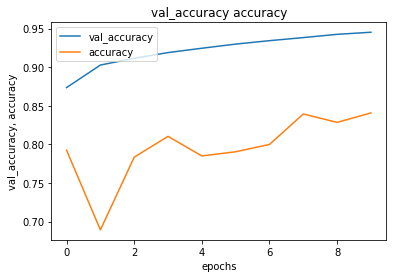

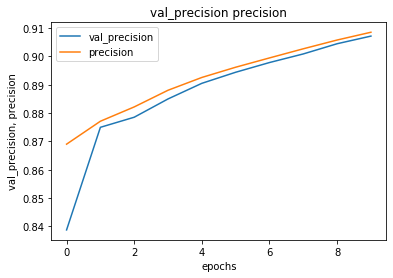

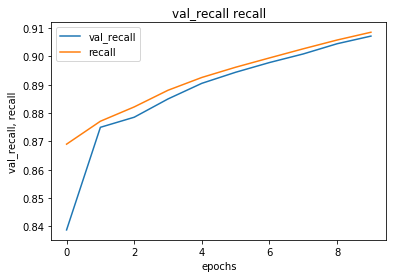

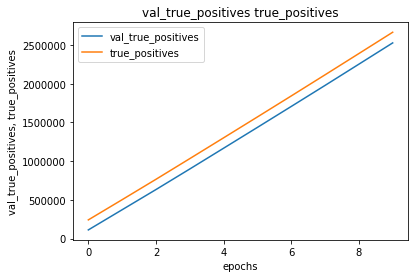

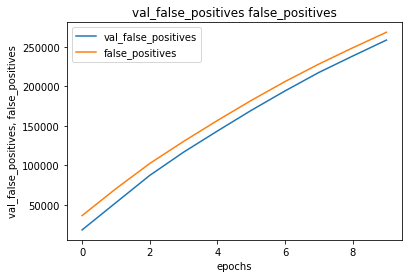

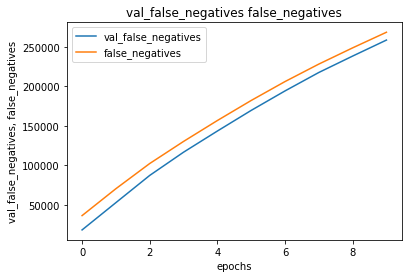

{'adaptive_gabor732.h5': {'Accuracy:': 0.83612060546875,
                          'F1_score': 0.8704673497036494,
                          'FalseNegatives:': 273549.96875,
                          'FalsePositives:': 273549.96875,
                          'Precision:': 0.9077569246292114,
                          'Recall:': 0.9077569246292114,
                          'Test loss:': 0.38152201294724364,
                          'TruePositives:': 2691970.5}}


In [9]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_gabor764.h5'

layers = am.gabor_layer(input_layer, 7, 64)

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model
model = am.define_model(input_layer, outputs_layer)

# Add filters from gabor function
weights, filters = am.gabor_filter(model)
model.layers[1].set_weights(weights)

history = train(model, x_train, y_train, x_valid, y_valid, model_name)
evaluate(model, x_test, y_test, history, model_name, results, counter)
pprint.pprint(results)

Train on 262144 samples, validate on 32768 samples
Epoch 1/10
262144/262144 [==============================] - 853s 3ms/step - loss: 0.3290 - precision_1: 0.8243 - accuracy: 0.8649 - recall_1: 0.8243 - true_positives_1: 111227.3359 - false_positives_1: 19852.4883 - false_negatives_1: 19852.4883 - val_loss: 0.5305 - val_precision_1: 0.8585 - val_accuracy: 0.7525 - val_recall_1: 0.8585 - val_true_positives_1: 239075.5312 - val_false_positives_1: 39458.5078 - val_false_negatives_1: 39458.5078
Epoch 2/10
262144/262144 [==============================] - 851s 3ms/step - loss: 0.2518 - precision_1: 0.8646 - accuracy: 0.8969 - recall_1: 0.8646 - true_positives_1: 368775.7812 - false_positives_1: 57216.0156 - false_negatives_1: 57216.0156 - val_loss: 0.6458 - val_precision_1: 0.8670 - val_accuracy: 0.6504 - val_recall_1: 0.8670 - val_true_positives_1: 497149.5938 - val_false_positives_1: 76296.1172 - val_false_negatives_1: 76296.1172
Epoch 3/10
262144/262144 [==============================] - 8

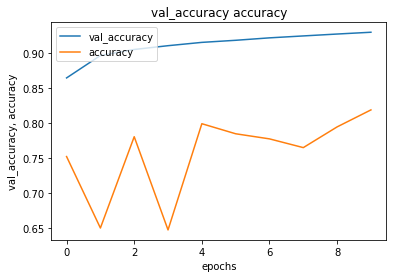

error
error
error
error
error
{'adaptive_gabor732.h5': {'Accuracy:': 0.83612060546875,
                          'F1_score': 0.8704673497036494,
                          'FalseNegatives:': 273549.96875,
                          'FalsePositives:': 273549.96875,
                          'Precision:': 0.9077569246292114,
                          'Recall:': 0.9077569246292114,
                          'Test loss:': 0.38152201294724364,
                          'TruePositives:': 2691970.5},
 'adaptive_gabor932.h5': {'Accuracy:': 0.811553955078125,
                          'F1_score': 0.8508483119822602,
                          'FalseNegatives:': 313928.1875,
                          'FalsePositives:': 313928.1875,
                          'Precision:': 0.8941415548324585,
                          'Recall:': 0.8941415548324585,
                          'Test loss:': 0.43249289083178155,
                          'TruePositives:': 2651592.25}}


In [10]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_gabor964.h5'

layers = am.gabor_layer(input_layer, 9, 64)

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model
model = am.define_model(input_layer, outputs_layer)

# Add filters from gabor function
weights, filters = am.gabor_filter(model)
model.layers[1].set_weights(weights)

history = train(model, x_train, y_train, x_valid, y_valid, model_name)
evaluate(model, x_test, y_test, history, model_name, results, counter)
pprint.pprint(results)


In [ ]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_gabor516.h5'

layers = am.gabor_layer(input_layer, 5, 16)

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model
model = am.define_model(input_layer, outputs_layer)

# Add filters from gabor function
weights, filters = am.gabor_filter(model)
model.layers[1].set_weights(weights)

history = train(model, x_train, y_train, x_valid, y_valid, model_name)
evaluate(model, x_test, y_test, history, model_name, results, counter)
pprint.pprint(results)

In [ ]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_gabor716.h5'

layers = am.gabor_layer(input_layer, 7, 16)

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model
model = am.define_model(input_layer, outputs_layer)

# Add filters from gabor function
weights, filters = am.gabor_filter(model)
model.layers[1].set_weights(weights)

history = train(model, x_train, y_train, x_valid, y_valid, model_name)
evaluate(model, x_test, y_test, history, model_name, results, counter)
pprint.pprint(results)

In [ ]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_gabor916.h5'

layers = am.gabor_layer(input_layer, 9, 16)

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model
model = am.define_model(input_layer, outputs_layer)

# Add filters from gabor function
weights, filters = am.gabor_filter(model)
model.layers[1].set_weights(weights)

history = train(model, x_train, y_train, x_valid, y_valid, model_name)
evaluate(model, x_test, y_test, history, model_name, results, counter)
pprint.pprint(results)

## Autoencoder

In [ ]:
# # Input layer with shape of data
# input_layer = am.input_layer(shape)
# model_name = 'adaptive_autoencoder332.h5'
#
# layers = am.encoder_layer(input_layer, 3, 32)
#
# # Use Unet architecture as main model
# outputs_layer = am.unet_model(layers)
#
# # Output layer
# outputs_layer = am.flatten_layer(outputs_layer)
# outputs_layer = am.output_layer(outputs_layer)
#
# # Define model
# model = am.define_model(input_layer, outputs_layer)
#
# history = train(model, x_train, y_train, x_valid, y_valid, model_name)
# evaluate(model, x_test, y_test, history, model_name, results, counter)
# pprint.pprint(results)
#

Train on 262144 samples, validate on 32768 samples
Epoch 1/10
262144/262144 [==============================] - 1183s 5ms/step - loss: 0.4426 - precision_1: 0.7380 - accuracy: 0.7991 - recall_1: 0.7380 - true_positives_1: 100672.8047 - false_positives_1: 30407.0547 - false_negatives_1: 30407.0547 - val_loss: 0.6084 - val_precision_1: 0.7935 - val_accuracy: 0.7035 - val_recall_1: 0.7935 - val_true_positives_1: 220998.4219 - val_false_positives_1: 57535.5039 - val_false_negatives_1: 57535.5039
Epoch 2/10
262144/262144 [==============================] - 1180s 5ms/step - loss: 0.2945 - precision_1: 0.8130 - accuracy: 0.8789 - recall_1: 0.8130 - true_positives_1: 347243.5625 - false_positives_1: 78747.7031 - false_negatives_1: 78748.5859 - val_loss: 0.4691 - val_precision_1: 0.8293 - val_accuracy: 0.7693 - val_recall_1: 0.8293 - val_true_positives_1: 475563.5000 - val_false_positives_1: 97881.3125 - val_false_negatives_1: 97882.3359
Epoch 3/10
262144/262144 [==============================] -

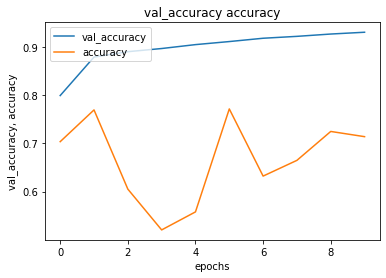

error
error
error
error
error
{'adaptive_autoencoder332.h5': {'Accuracy:': 0.70355224609375,
                                'F1_score': 0.7822809071990213,
                                'FalseNegatives:': 353347.15625,
                                'FalsePositives:': 353347.15625,
                                'Precision:': 0.8808495402336121,
                                'Recall:': 0.8808495402336121,
                                'Test loss:': 0.703238066907943,
                                'TruePositives:': 2612172.25},
 'adaptive_autoencoder532.h5': {'Accuracy:': 0.70458984375,
                                'F1_score': 0.7790416019011681,
                                'FalseNegatives:': 382298.75,
                                'FalsePositives:': 382297.65625,
                                'Precision:': 0.8710867762565613,
                                'Recall:': 0.8710866570472717,
                                'Test loss:': 0.9821640031223069,
          

In [10]:
# # Input layer with shape of data
# input_layer = am.input_layer(shape)
# model_name = 'adaptive_autoencoder532.h5'
#
# layers = am.encoder_layer(input_layer, 5, 32)
#
# # Use Unet architecture as main model
# outputs_layer = am.unet_model(layers)
#
# # Output layer
# outputs_layer = am.flatten_layer(outputs_layer)
# outputs_layer = am.output_layer(outputs_layer)
#
# # Define model
# model = am.define_model(input_layer, outputs_layer)
#
# history = train(model, x_train, y_train, x_valid, y_valid, model_name)
# evaluate(model, x_test, y_test, history, model_name, results, counter)
# pprint.pprint(results)
#

Train on 262144 samples, validate on 32768 samples
Epoch 1/10
262144/262144 [==============================] - 1387s 5ms/step - loss: 0.4627 - precision_3: 0.7515 - accuracy: 0.7881 - recall_3: 0.7515 - true_positives_3: 101370.7734 - false_positives_3: 29709.1172 - false_negatives_3: 29709.1172 - val_loss: 0.5748 - val_precision_3: 0.7833 - val_accuracy: 0.7018 - val_recall_3: 0.7833 - val_true_positives_3: 218141.1250 - val_false_positives_3: 60392.7305 - val_false_negatives_3: 60392.7305
Epoch 2/10
262144/262144 [==============================] - 1315s 5ms/step - loss: 0.3429 - precision_3: 0.7958 - accuracy: 0.8539 - recall_3: 0.7958 - true_positives_3: 339832.0938 - false_positives_3: 86159.9531 - false_negatives_3: 86159.9531 - val_loss: 0.9605 - val_precision_3: 0.8053 - val_accuracy: 0.5093 - val_recall_3: 0.8053 - val_true_positives_3: 461746.5312 - val_false_positives_3: 111699.4844 - val_false_negatives_3: 111699.4844
Epoch 3/10
262144/262144 [==============================]

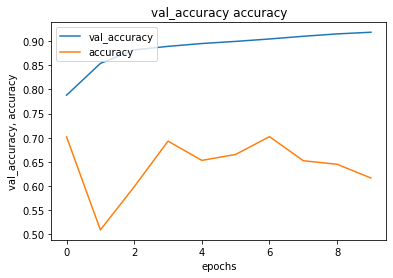

error
error
error
error
error
{'adaptive_autoencoder332.h5': {'Accuracy:': 0.70355224609375,
                                'F1_score': 0.7822809071990213,
                                'FalseNegatives:': 353347.15625,
                                'FalsePositives:': 353347.15625,
                                'Precision:': 0.8808495402336121,
                                'Recall:': 0.8808495402336121,
                                'Test loss:': 0.703238066907943,
                                'TruePositives:': 2612172.25},
 'adaptive_autoencoder532.h5': {'Accuracy:': 0.70458984375,
                                'F1_score': 0.7790416019011681,
                                'FalseNegatives:': 382298.75,
                                'FalsePositives:': 382297.65625,
                                'Precision:': 0.8710867762565613,
                                'Recall:': 0.8710866570472717,
                                'Test loss:': 0.9821640031223069,
          

In [12]:
# # Input layer with shape of data
# input_layer = am.input_layer(shape)
# model_name = 'adaptive_autoencoder732.h5'
#
# layers = am.encoder_layer(input_layer, 7, 32)
#
# # Use Unet architecture as main model
# outputs_layer = am.unet_model(layers)
#
# # Output layer
# outputs_layer = am.flatten_layer(outputs_layer)
# outputs_layer = am.output_layer(outputs_layer)
#
# # Define model
# model = am.define_model(input_layer, outputs_layer)
#
# history = train(model, x_train, y_train, x_valid, y_valid, model_name)
# evaluate(model, x_test, y_test, history, model_name, results, counter)
# pprint.pprint(results)


